<a href="https://colab.research.google.com/github/AdolfoBanchio/Redes-neuronales-2024/blob/main/guias_ejercicios/redes_neuronales_2024_guia_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El modelo *Integrate and Fire*

## Teoría

El modelo *Integrate and Fire* del comportamiento de una neurona viene descripto por dos ingredientes. En primer lugar, la ODE

\begin{align*}
\frac{dV}{dt}
&=&
\frac{1}{\tau}
\left(
E-V(t)
+
RI(t)
\right)
\end{align*}

donde:

* $V(t)$ representa el potencial de membrana al tiempo $t$,

* $E\approx -65mV$ representa el potencial de reposo,

* $\tau\approx 10ms$ representa el tiempo de relajación,

* $R\approx 10M\Omega$ representa una resistencia eléctrica, y

* $I(t)\approx 1nA$ representa una corriente/señal de entrada.

En segundo lugar, un mecanismo de disparo definido por

\begin{align*}
V(t) \to E
\end{align*}

cuando

\begin{align*}
V(t) > V_u
\end{align*}

donde:

* $V_u \approx -50mV$ representa un potencial umbral.

Es decir, según el mecanismo de disparo, el potencial de membrana $V(t)$ se resetea a su valor de reposo $E$ si supera cierto valor umbral $V_u$.

## Unidades

* p = pico = $10^{-12}$
* n = nano = $10^{-9}$
* $\mu$ = micro = $10^{-6}$
* m = mili = $10^{-3}$
* ...
* k = kilo = $10^{3}$
* M = Mega = $10^{6}$
* G = Giga = $10^{9}$
* T = Tera = $10^{12}$

### Ley de Ohm

Si $\Omega$ = Ohmio, V = Voltio y A = Amper, entonces

$$ 1\, Ohm = 1 \Omega = \frac{1 V}{1 A} $$

### Ley RC

Si s = segundos y F = Faradios, entonces

$$ 1 s = 1 \Omega \times 1 F $$

### Hertz

Si Hz = Hertz, luego

$$ 1 Hz = \frac{1}{1 s} $$

### Referencias

* https://technologystudent.com/elec1/ohm1.htm

* https://en.wikipedia.org/wiki/Biological_neuron_model#Leaky_integrate-and-fire

* https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html



## **Ejercicio 1)** Importando librerías

**1)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**2)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [190]:
# 1.1)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [191]:
# 1.2)
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Ejercicio 2)** Dinámica con mecanismo de disparo desactivado

En lo que sigue, se considera desactivado el mecanismo de disparo.

**1)** Resuelva analíticamente la ODE del modelo *Integrate and Fire* para una condición inicial arbitraria $V(0)=V_0$ y una corriente de entrada $I=0$.

**2)** Grafique la solución para $V_0=10mV$ y $t\in [0,100]ms$. Incorpore al gráfico una línea punteada indicando el potencial de reposo.

**3)** Realice un análisis geométrico de la solución calculada. Incorpore flechas del campo vectorial así como los puntos fijos estables, inestables y marginales, si los hubiere.

**4)** Repita **1)**, **2)** y **3)** para el caso de corriente de entrada constante, $I=2nA$.

### Extra

**5)** Resuelva analíticamente la ODE para una corriente de entrada $I:t\to I(t)$ arbitraria.

Partimos de la ODE para $I=0$

$$
\begin{align*}
\frac{dV}{dt} &= \frac{1}{\tau}\left( E-V(t)+ RI(t) \right) \\
\frac{dV}{dt} &= \frac{1}{\tau}\left( E-V(t) \right) \\
\frac{dV}{E-V(t)} &= \frac{1}{\tau}dt \\
\text{Integro ambos lados} \\
\int \frac{dV}{E-V(t)} &= \int \frac{1}{\tau}dt \\
-\ln|E-V(t)| &= \frac{t}{\tau} + C \\
\ln|E-V(t)| &= -\frac{t}{\tau} + C \\
E-V(t) &= e^{-\frac{t}{\tau} + C} = e^{-\frac{t}{\tau}}e^C \\
\textrm{Sea } C_1 &= e^C \textrm{, entonces } \\
E-V(t) &= C_1e^{-\frac{t}{\tau}} \\

\text{Aplico las condiciones iniciales para }& t=0,V(0)=V_0 \\
E-V_0 &= C_1e^0 \rightarrow C_1 = E - V_0\\
\text{Entonces la solucion es:} \\
V(t) &= E - (E - V_0)e^{-\frac{t}{\tau}} \\
\end{align*}
$$

In [192]:
# 2.1) Graficar solución de la ecuación diferencial para v0 = 10 y t in [0,100]
def ode_sol_1(t,v0):
    """ 
    Solucion analitica para la  ODE 
    dV/dt = 1/tao (E - V + R*I)
    con condicion inicial
    V(0) = v0 
    I = 0

    Los valores las constantes son:
    E = -65mV
    tao = 10ms
    """
    E = -65
    tao = 10
    return E - (E-v0)*np.exp(-t/tao)

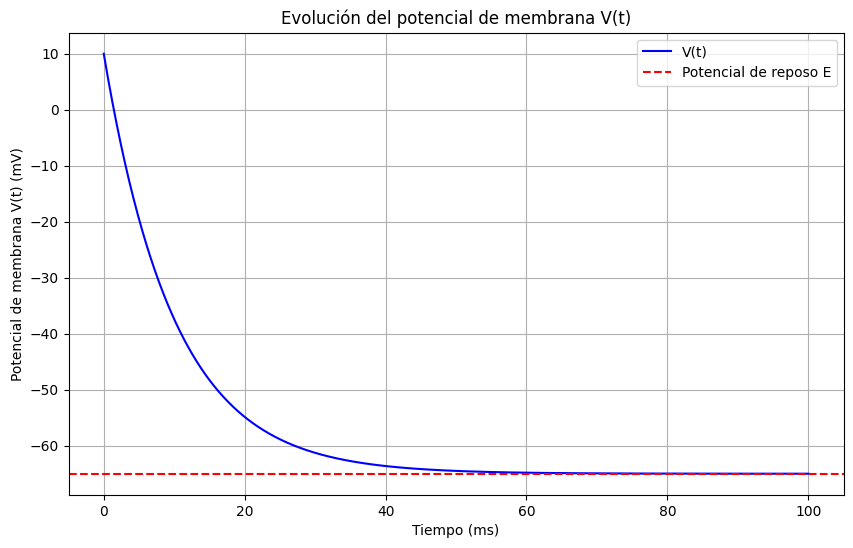

In [193]:
# 2.2)
t = np.linspace(0,100,1000)
v0 = 10
plt.figure(figsize=(10, 6))
plt.plot(t, ode_sol_1(t,v0), label='V(t)', color='b')
plt.axhline(y=-65, color='r', linestyle='--', label='Potencial de reposo E')
plt.title('Evolución del potencial de membrana V(t)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana V(t) (mV)')
plt.legend()
plt.grid(True)
plt.show()

2.3)
En este lo que voy a haer va a ser calcular el valor de la ecuacion diferencial, para los diferentes valores que veo que toma la variable V(t) (por el ejercicio anterior veo que vive entre 10 y -70). 

Voy a graficar dV/dt en funcion de V(t).
Por la forma de la ODE
$$\frac{dV}{dt} = \frac{1}{\tau}\left( E-V(t) \right) \\$$

Es facil ver que el unico punto fijo (es decir cuando la razon de cambio es nula) es cuando V(t) = E.

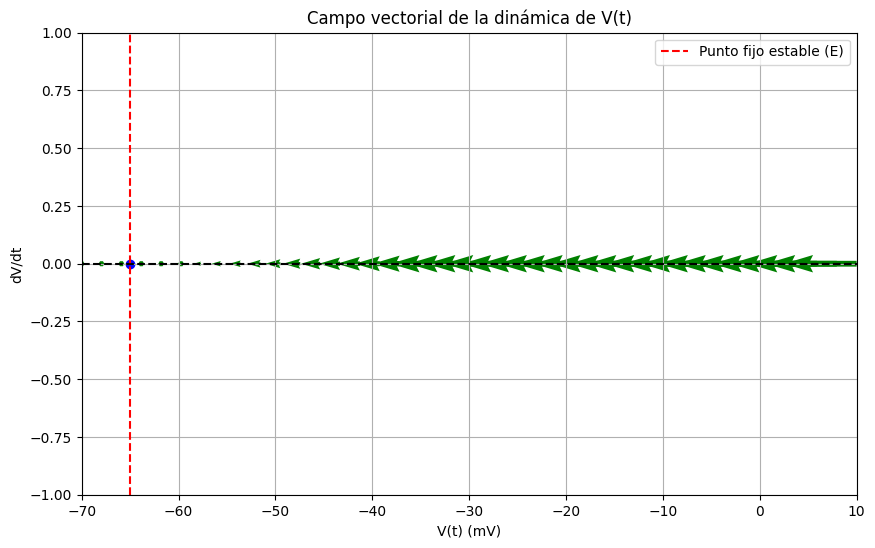

In [194]:
# Campo vectorial
V_values = np.linspace(-70, 10, 40)  # Valores de V(t) para el campo vectorial
dV_dt = (-65 - V_values) / 10  # Derivada de V(t) respecto a t

# Graficar el campo vectorial
plt.figure(figsize=(10, 6))
plt.quiver(V_values, np.zeros_like(V_values), dV_dt, np.zeros_like(dV_dt), angles='xy', scale_units='xy', scale=1, color='g')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=-65, color='r', linestyle='--', label='Punto fijo estable (E)')
plt.scatter(-65, 0, color='b')

# quiver(x,y,u,v, {ops}) x e y el origen de cada vector u y v son las componentes del vector
# Configuración de la gráfica
plt.title('Campo vectorial de la dinámica de V(t)')
plt.xlabel('V(t) (mV)')
plt.ylabel('dV/dt')
plt.xlim([-70, 10])
plt.ylim([-1, 1])
plt.grid(True)
plt.legend()
plt.show()

Resuelvo la EDO:
$$\frac{dV}{dt} = \frac{1}{\tau}\left( E-V(t)+ RI(t) \right)$$

Para $I(t)=2nA$
Resuelvo la EDO:
$$
\begin{align*}
\frac{dV}{dt} &= \frac{1}{\tau}\left( E-V(t)+ RI(t) \right) \\
\frac{dV}{dt} &= \frac{1}{\tau}\left( E-V(t)+ R*2nA \right) \\
\frac{dV}{E-V(t)+ R*2nA} &= \frac{1}{\tau}dt \\
\text{Integro ambos lados} \\
\int \frac{dV}{E-V(t)+ R*2nA} &= \int \frac{1}{\tau}dt \\
-\ln|E-V(t)+ R*2nA| &= \frac{t}{\tau} + C \\
\ln|E-V(t)+ R*2nA| &= -\frac{t}{\tau} + C \\
E-V(t)+ R*2nA &= e^{-\frac{t}{\tau} + C} = e^{-\frac{t}{\tau}}e^C \\
\textrm{Sea } C_1 &= e^C \textrm{, entonces } \\
E-V(t)+ R*2nA &= C_1e^{-\frac{t}{\tau}} \\
\text{Aplico las condiciones iniciales para }& t=0,V(0)=V_0 \\
E-V_0+ R*2nA &= C_1e^0 \rightarrow C_1 = E - V_0 + R*2nA\\
\text{Entonces la solucion es:} \\
V(t) &= E - (E - V_0 + R*2nA)e^{-\frac{t}{\tau}} - R*2nA \\
\end{align*}
$$

In [195]:
def ode_sol_2(t, v0):
    """
    Solucion analitica para la  ODE 
    dV/dt = 1/tao (E - V + R*I)
    con condicion inicial
    V(0) = v0 
    I = 2

    Los valores las constantes son:
    E = -65mV
    tao = 10ms
    R = 10
    """
    E = -65
    tao = 10
    R = 10
    return E -(E - v0 + R*2)*np.exp(-t/tao) - 2*R

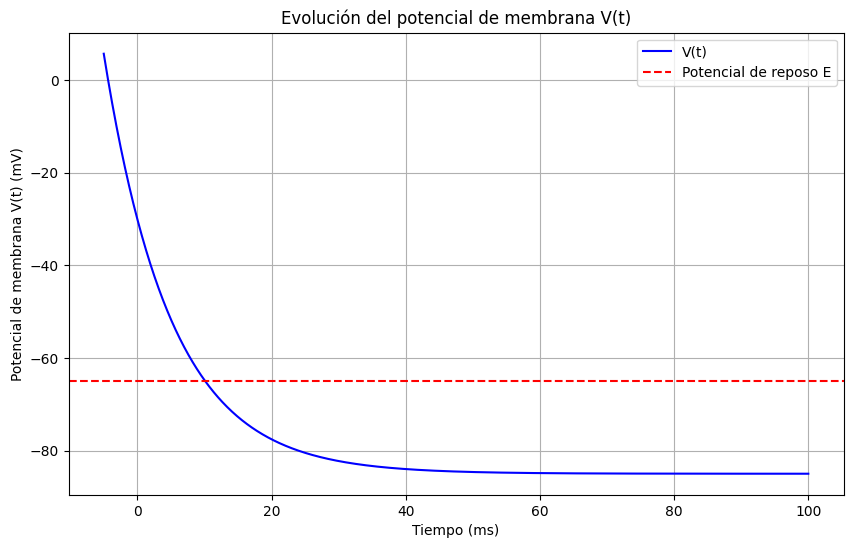

In [202]:
# Graficar solución de la ecuación diferencial para v0 = 10 y t in [0,100]
t_2 = np.linspace(-5,100,1000)
v0_2 = 10
plt.figure(figsize=(10, 6))
plt.plot(t_2, ode_sol_2(t_2,v0_2), label='V(t)', color='b')
plt.axhline(y=-65, color='r', linestyle='--', label='Potencial de reposo E')
plt.title('Evolución del potencial de membrana V(t)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana V(t) (mV)')
plt.legend()
plt.grid(True)
plt.show()

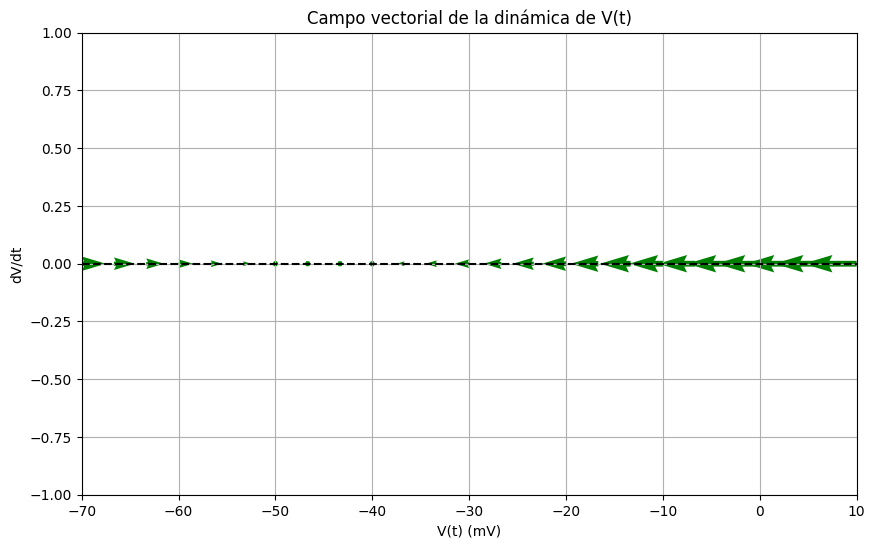

In [201]:
# Campo vectorial
V_values_2 = np.linspace(-70, 10, 25)  # Valores de V(t) para el campo vectorial
dV_dt_2 = (-65 - V_values + 10*2) / 10  # Derivada de V(t) respecto a t

# Graficar el campo vectorial
plt.figure(figsize=(10, 6))
plt.quiver(V_values_2, np.zeros_like(V_values_2), dV_dt_2, np.zeros_like(dV_dt_2), angles='xy', scale_units='xy', scale=1, color='g')
plt.axhline(y=0, color='k', linestyle='--')


# Configuración de la gráfica
plt.title('Campo vectorial de la dinámica de V(t)')
plt.xlabel('V(t) (mV)')
plt.ylabel('dV/dt')
plt.xlim([-70, 10])
plt.ylim([-1, 1])
plt.grid(True)
plt.show()

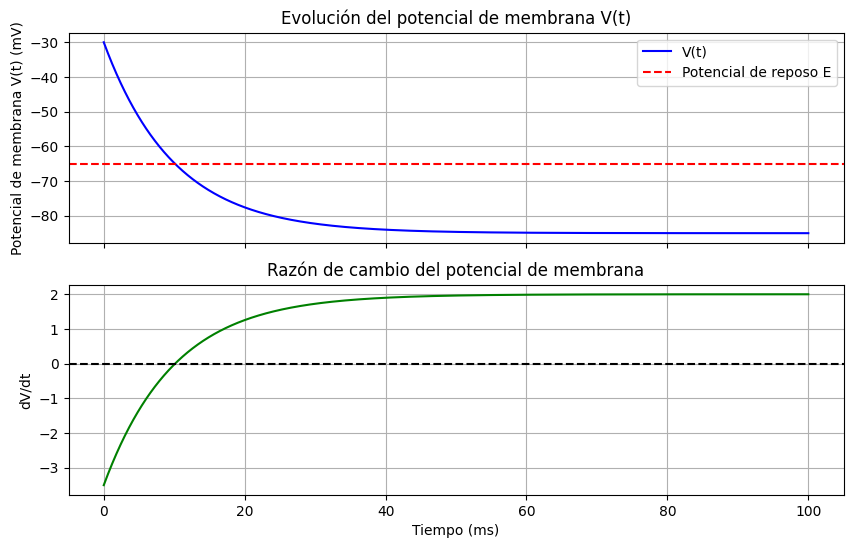

In [204]:
# grafico de v(t) (el potencial) y su razon de cambio
t = np.linspace(0,100,2000)
v0 = 10
dv = lambda v: (-65 - v) / 10
fg, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(t, ode_sol_2(t,v0), label='V(t)', color='b')
ax[0].axhline(y=-65, color='r', linestyle='--', label='Potencial de reposo E')
ax[0].set_title('Evolución del potencial de membrana V(t)')
ax[0].set_ylabel('Potencial de membrana V(t) (mV)')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(t, dv(ode_sol_2(t,v0)), label='dV/dt', color='g')
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_title('Razón de cambio del potencial de membrana')
ax[1].set_xlabel('Tiempo (ms)')
ax[1].set_ylabel('dV/dt')
ax[1].grid(True)
plt.show()

## **Ejercicio 3)** Dinámica con mecanismo de disparo activado

**1)** Resuelva numéricamente la ODE del modelo *Integrate and Fire* en el intervalo $t\in [0,200]ms$ para la condición inicial $V(0)=E$ y una corriente de entrada $I(t)=I_0$ para todo $t$ con $I_0=2nA$. Utilice el paso de integración $h=0.05ms$.

**2)** Grafique la solución computada en el inciso **3.1)**. Incorpore al gráfico la solución exacta del inciso **2.1)**, en donde el mecanismo de disparo está desactivado, para la misma condición inicial del inciso **3.1)**. Grafique, también, líneas punteadas horizontales marcando los valores de $V^*$ y $V_u$, donde $V^*$ es el valor de $V$ tal que $f(V)=0$.

**3)** Para el caso indicado en el inciso **3.1)**, calcule analíticamente el período de disparo.
Observe si el valor computado corresponde con el observado en el inciso **3.2)**.
Grafíque la frencuencia en función de $I_0$.
Que ocurre para valores pequeños de $I_0$?


**4)** Repita **3.1)** y **3.2)** con $I_e(t)=I_0 \cos(t/30ms)$ e $I_0=2.5nA$ para $0\,ms\leq t\leq 500\,ms$. En este caso, no incluya la solución exacta del inciso **2.1)**, pero sí lineas punteadas horizontales para marcar los valores de $E$ y $V_u$.

**5)** Repita **3.1)** y **3.2)** con

\begin{equation}
I(t)= I_0 \, \left(
    \cos{\left( \frac{t}{3ms} \right)} +
    \sin{\left( \frac{t}{5ms} \right)} +
    \cos{\left( \frac{t}{7ms} \right)} +
    \sin{\left( \frac{t}{11ms} \right)} +
    \cos{\left( \frac{t}{13ms} \right)}  \right)^2 \, nA \,
    \;\;\;(4)
\end{equation}

e $I_0=0.35 nA$ para $0\,ms\leq t\leq 200\,ms$. Al igual que en inciso anterior, no incluya la solución exacta del inciso **2.a)**, pero sí lineas punteadas horizontales para marcar los valores de $E$ y $V_u$.

* $V(t)$ representa el potencial de membrana al tiempo $t$,

* $E\approx -65mV$ representa el potencial de reposo,

* $\tau\approx 10ms$ representa el tiempo de relajación,

* $R\approx 10M\Omega$ representa una resistencia eléctrica, y

* $I(t)\approx 1nA$ representa una corriente/señal de entrada.

In [ ]:
# 3.1)
def i_and_fire(x,t,p):
    """  
    Modelo de neurona de integración y disparo. Dado por la ODE:
    dV/dt = 1/tao (E - V + R*I)
    Donde los parametros son:
    
    V = Potencial de membrana (mV)
    E = Potencial de reposo (-65mV)
    tao = tiempo de relajación (10ms)
    R = resistencia electrica (10mV/nA)
    I(t) = corriente de entrada (nA)

    Donde las condiciones iniciales son:
    V(0) = v0
    I(t) = i0
    """
    E = p[0]
    tao = p[1]
    R = p[2]
    I = p[3] # Corriente de entrada
    return np.array([(E - x + R*I(t))/tao])

def c(x,t,p):
    """ 
    Funcion condicionante para el integrate and fire.

    Si el potencial de membrana supera el umbral de disparo (Vth = -50mV),
    se produce un disparo y el potencial de membrana se resetea a -65mV.  
    """
    vth = -50
    if x[0] > vth:
        x[0] = p[0]
    return x

In [ ]:
a = 0
b = 200 # rango de tiempo
h = 0.05 # paso de integración
k = int((b-a)/h) # numero de pasos de integración
xa = -65 # Condición inicial
p = np.array([-65, 10, 10, lambda t: 2]) # Parametros

In [ ]:
t_sol_num, w_sol_num = integrador_ode(rk4, i_and_fire, np.array([xa]), a, b, k, p, c)

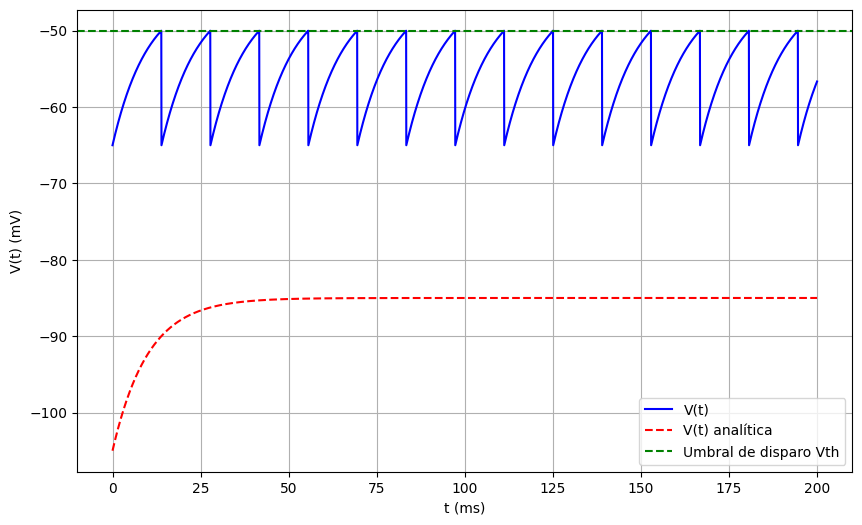

In [ ]:
# 3.2)
# Graficar la solución numérica de la ecuación diferencial y ls solución analítica
# con condicion inicial V(0) = -65mV
plt.figure(figsize=(10, 6))
plt.plot(t_sol_num, w_sol_num[0], label='V(t)', color='b')
plt.plot(t_sol_num, ode_sol_2(t_sol_num, xa), label='V(t) analítica', color='r', linestyle='--')

# Marcar lineas horizontales en V_th (el umbral de disparo) 
plt.axhline(y=-50, color='g', linestyle='--', label='Umbral de disparo Vth')
# y V* donde F(V*) = 0, cuando la razón de cambio de V es 0

# Configuración de la gráfica
plt.xlabel('t (ms)')
plt.ylabel('V(t) (mV)')
plt.grid(True)
plt.legend()
plt.show()

3.3) Calcular el periodo de disparo de la grafica anterior, es decir de solucion numerica de integrate and fire con valor de corriente constante de 2nA y condicion inicial de V(0) = E = -65mV.

4) Repetir lo anterior pero utilizando 
$$I(t)=I_0 \cos(t/30ms)$$
con $I_0=2.5nA$ para $0ms\leq t\leq 500ms$.

In [ ]:
a = 0
b = 200 # rango de tiempo
h = 0.05 # paso de integración
k = int((b-a)/h) # numero de pasos de integración
xa = -65 # Condición inicial
I = lambda t: 2.5*np.cos(t/30)
p = np.array([-65, 10, 10, I]) # Parametros

In [ ]:
t_sol_num2, w_sol_num2 = integrador_ode(rk4, i_and_fire, np.array([xa]), a, b, k, p, c)

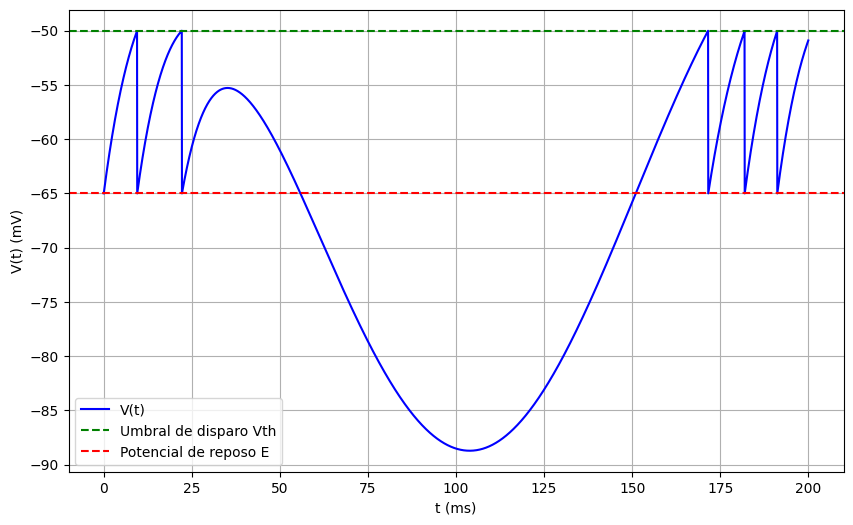

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_sol_num2, w_sol_num2[0], label='V(t)', color='b')
plt.axhline(y=-50, color='g', linestyle='--', label='Umbral de disparo Vth')
plt.axhline(y=-65, color='r', linestyle='--', label='Potencial de reposo E')
plt.xlabel('t (ms)')
plt.ylabel('V(t) (mV)')
plt.grid(True)
plt.legend()
plt.show()

5) Repetir lo anterior pero utilizando
\begin{align*}
I(t)= I_0 \, \left(
    \cos{\left( \frac{t}{3ms} \right)} +
    \sin{\left( \frac{t}{5ms} \right)} +
    \cos{\left( \frac{t}{7ms} \right)} +
    \sin{\left( \frac{t}{11ms} \right)} +
    \cos{\left( \frac{t}{13ms} \right)}  \right)^2 \, nA \,
    \;\;\;(4)
\end{align*}

e $I_0=0.35 nA$ para $0\,ms\leq t\leq 200\,ms$

In [ ]:
a = 0
b = 200 # rango de tiempo
h = 0.05 # paso de integración
k = int((b-a)/h) # numero de pasos de integración
xa = -65 # Condición inicial
I = lambda t: 0.35*(np.cos(t/3)+np.sin(t/5)+np.cos(t/7)+np.sin(t/11)+np.cos(t/13))**2
p = np.array([-65, 10, 10, I]) # Parametros

In [ ]:
t_sol_num3, w_sol_num3 = integrador_ode(rk4, i_and_fire, np.array([xa]), a, b, k, p, c)
t_sol3_alt, w_sol3_alt = integrador_ode(rk4, i_and_fire, np.array([xa]), a, b, k, p)

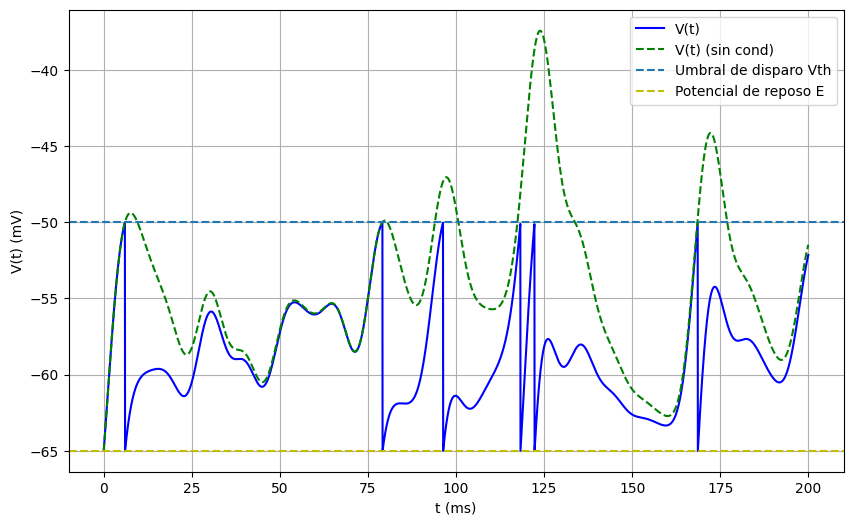

In [205]:
plt.figure(figsize=(10, 6))
plt.plot(t_sol_num3, w_sol_num3[0], label='V(t)', color='b')
plt.plot(t_sol3_alt, w_sol3_alt[0], label='V(t) (sin cond)', color='g', linestyle='--')


plt.axhline(y=-50 , linestyle='--', label='Umbral de disparo Vth')
plt.axhline(y=-65,color='y', linestyle='--', label='Potencial de reposo E')
plt.xlabel('t (ms)')
plt.ylabel('V(t) (mV)')
plt.grid(True)
plt.legend()
plt.show()